# Stimulation of Crayfish Ganglia

## Step 1: Format Recording
In this first section, we reformat the raw recording into a fiff file, thereby making it compatible with the *mne-python* package. This will come in handy for preprocessing and analysis.

In [39]:
import neo
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/17927009.abf'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load recordings.
recordings, = neo.AxonIO(filename=f).read_block().segments
muscle, stim = recordings.analogsignals

## Concatenate raw recordings.
data = np.hstack([np.asarray(muscle, dtype=np.float64)  * 1e-3, # uV --> V 
                  np.asarray(stim, dtype=np.float64)
                 ]).T

## Create info object.
sfreq = float(muscle.sampling_rate)
ch_names = ['muscle', 'stim']
ch_types = 'bio'

info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

## Create Raw object.
raw = RawArray(data, info)

## Save Raw object.
raw.save('raw/stimulation_raw.fif', overwrite=True, verbose=False)
print('Done.')

Creating RawArray with float64 data, n_channels=2, n_times=103224
    Range : 0 ... 103223 =      0.000 ...    10.322 secs
Ready.
Done.


## Step 2: Preprocess Recording
Next, we open the raw FIFF file and preform preprocessing. For this dataset, preprocessing will entail only filtering the data to remove slow-frequency drifts and high-frequency noise.

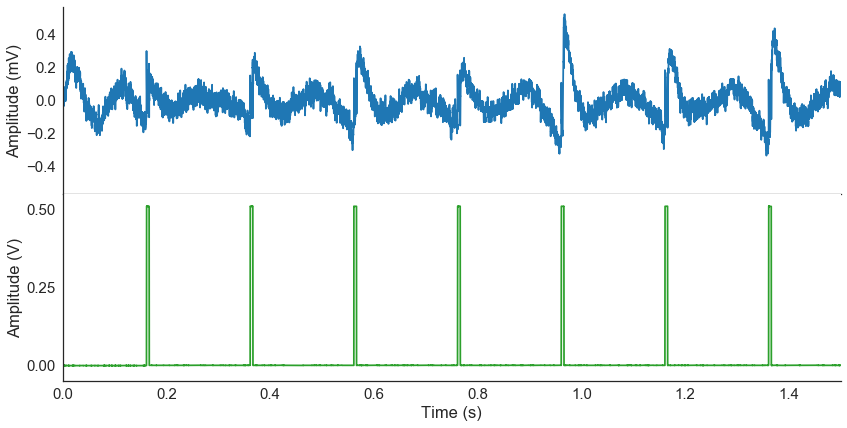

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import pick_channels
from mne.io import Raw
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/stimulation_raw.fif'

## Filter parameters (nerve).
filter_dict = dict( muscle = (10, None) )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load raw.
raw = Raw(f, preload=True, verbose=False)

## Filter data.
for k, v in filter_dict.items():
    picks = pick_channels(raw.ch_names, include=[k])
    raw = raw.filter(*v, picks=picks, method='fir', phase='zero')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6),sharex=True)

## Extract data.
data, times = raw.get_data(stop=raw.time_as_index(tmax)[0], return_times=True)

## Iteratively plot.
yscales = [1e3, 1e0]
ylabels = [r'Amplitude (mV)', r'Amplitude (V)']
colors = ['#1f77b4', '#2ca02c']

for ax, arr, color, yscale, ylabel in zip(axes, data, colors, yscales, ylabels):

    ## Plot.
    ax.plot(times, arr * yscale, color=color)
    y = np.abs(ax.get_ylim()).max()
    ax.set(xlim=(times.min(), times.max()), ylim=(-y, y), ylabel=ylabel)
    
ax.set(xlabel='Time (s)', ylim=(-0.05, 0.55), yticks=(0,0.25,0.5))
sns.despine()
plt.subplots_adjust(left=0.05, right=0.95, top=0.99, hspace=0)